In [1]:

import numpy as np
import pandas as pd
import random 

#plot
#import plotly.graph_objects as go 
#from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

#keras
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#scikit-learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
    

2022-03-28 08:22:35.131842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 08:22:35.131976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def balancedCut(df ,n ,frac = [0.5], target = 'Class',classes=[0,1]):
    random.seed(1)
    print(f'{"="*50}\nbalancedCut\n{"="*50}')
    print(f'Realizando seleccion de la muestra la muestra')
    newDfs = []
    if sum(frac) > 1:
        print(f'Valor de la fraccion incorrecto: --> {sum(frac)} > 1')
        
    if len(frac) < len(classes):
        frac.append(1-sum(frac))
    
    for cl,fc in zip(classes, frac):
        ndf = df[df[target]==cl]
        ro = ndf.shape[0]
        print(f'Dataset de clase --> {cl}')
        if int(fc*n) > ro:
            newDfs.append(ndf)
            print(f'\tFilas: {ro}')
        else:
            newDfs.append(ndf.sample(n=int(fc*n)))
            print(f'\tFilas: {int(fc*n)}')
    
    return pd.concat(newDfs), newDfs[1].shape[0]/newDfs[0].shape[0]

In [3]:
cards = pd.read_csv("/home/vcalzada/Work/proyecto/modelos/creditcard.csv")
cards = cards.sample(frac=1)


cards.head()

df, frac = balancedCut(cards, 4000, frac=[0.9])

balancedCut
Realizando seleccion de la muestra la muestra
Dataset de clase --> 0
	Filas: 3600
Dataset de clase --> 1
	Filas: 399


In [4]:
x = df.iloc[:,0:-1].to_numpy()

y = df.iloc[:,-1].to_numpy() 
scaler = StandardScaler()
x = scaler.fit_transform(x)

<div class="alert alert-warning" role="alert">
    <h1>Hay que escalar los datos!!</h1>
</div>

## PCA

In [5]:
pca = PCA(n_components=2)
pca.fit(x)
X_pca = pca.transform(x)

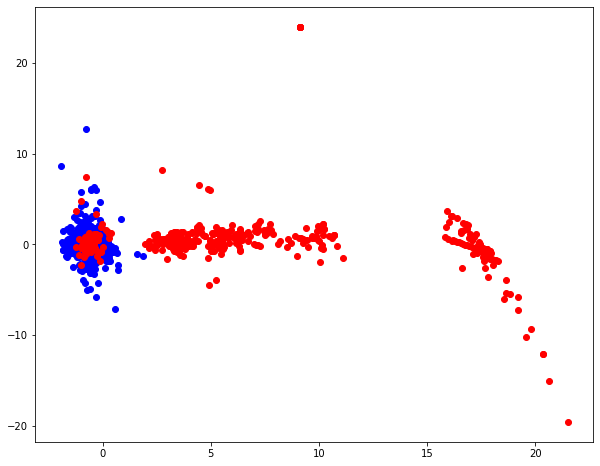

In [6]:
fig = plt.figure(figsize=(10,8))
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], color="blue")
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], color="red")
plt.show()

## Autoencoder

In [7]:
for i in range(10):
    print(2**i)

1
2
4
8
16
32
64
128
256
512


In [5]:
m = Sequential()
m.add(Dense(512,  activation='elu', input_shape=(30,)))
m.add(Dense(128,  activation='elu'))
m.add(Dense(2,    activation='linear', name="bottleneck"))
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(30,  activation='sigmoid'))

2022-03-28 08:22:45.580286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-28 08:22:45.580591: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-28 08:22:45.580664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (L-1802005): /proc/driver/nvidia/version does not exist
2022-03-28 08:22:45.581469: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print(m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15872     
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 bottleneck (Dense)          (None, 2)                 258       
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 dense_4 (Dense)             (None, 30)                15390     
                                                                 
Total params: 163,616
Trainable params: 163,616
Non-trai

In [18]:
m.compile(loss='mean_squared_error', optimizer = Adam())
history = m.fit(x, x, batch_size=20, epochs=10, verbose=1, 
                validation_data=(x, x))

encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(x)  # bottleneck representation
Renc = m.predict(x)        # reconstruction

Epoch 1/10
200/200 [==============================] - 7s 25ms/step - loss: 0.9634 - val_loss: 0.9306
Epoch 2/10
200/200 [==============================] - 5s 25ms/step - loss: 0.9248 - val_loss: 0.9213
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 0.9173 - val_loss: 0.9158
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.9123 - val_loss: 0.9110
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.9085 - val_loss: 0.9089
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.9080 - val_loss: 0.9042
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.9036 - val_loss: 0.9023
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.9015 - val_loss: 0.8962
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.8967 - val_loss: 0.8985
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.8954 - val_los

In [10]:
Zenc.shape

(3999, 2)

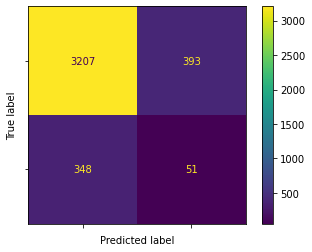

In [19]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

clf = LocalOutlierFactor(n_neighbors=100, contamination=frac, novelty=False)
y_pred = clf.fit_predict(Zenc[:,:])
y_pred[y_pred==1]=0
y_pred[y_pred==-1]=1
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[])
disp.plot()

In [20]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3600
           1       0.11      0.13      0.12       399

    accuracy                           0.81      3999
   macro avg       0.51      0.51      0.51      3999
weighted avg       0.82      0.81      0.82      3999



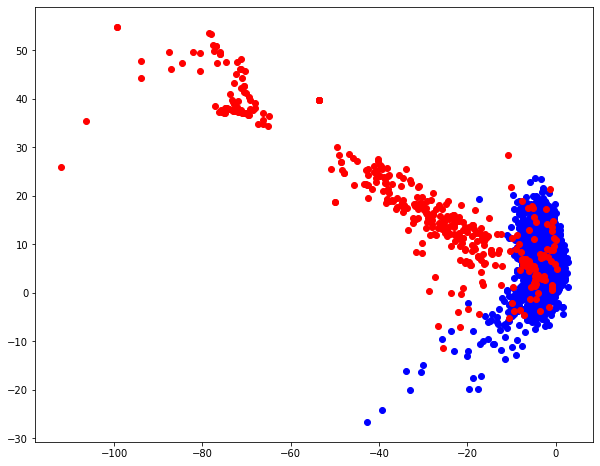

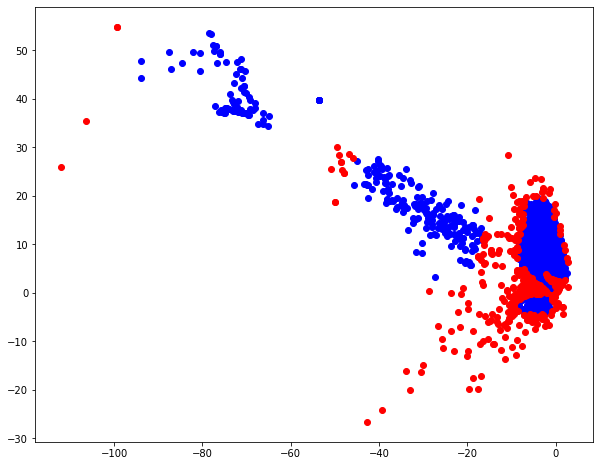

In [13]:
fig = plt.figure(figsize=(10,8))
plt.scatter(Zenc[y==0,0], Zenc[y==0,1], color="blue")
plt.scatter(Zenc[y==1,0], Zenc[y==1,1], color="red")
plt.show()

fig = plt.figure(figsize=(10,8))
plt.scatter(Zenc[y_pred==0,0], Zenc[y_pred==0,1], color="blue")
plt.scatter(Zenc[y_pred==1,0], Zenc[y_pred==1,1], color="red")
plt.show()

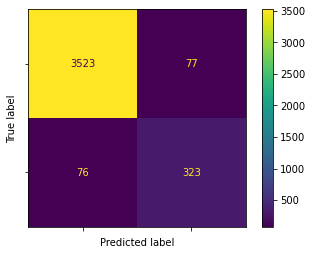

In [24]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(random_state = 1, contamination= 0.1)
y_pred = iso.fit_predict(Zenc[:,:])
y_pred[y_pred==1]=0
y_pred[y_pred==-1]=1
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[])
disp.plot()

In [25]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3600
           1       0.81      0.81      0.81       399

    accuracy                           0.96      3999
   macro avg       0.89      0.89      0.89      3999
weighted avg       0.96      0.96      0.96      3999



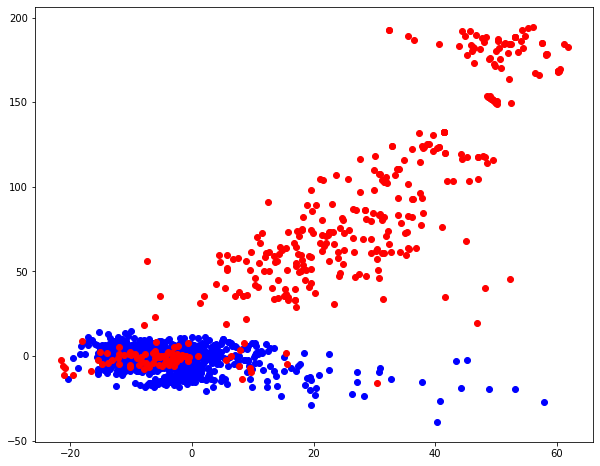

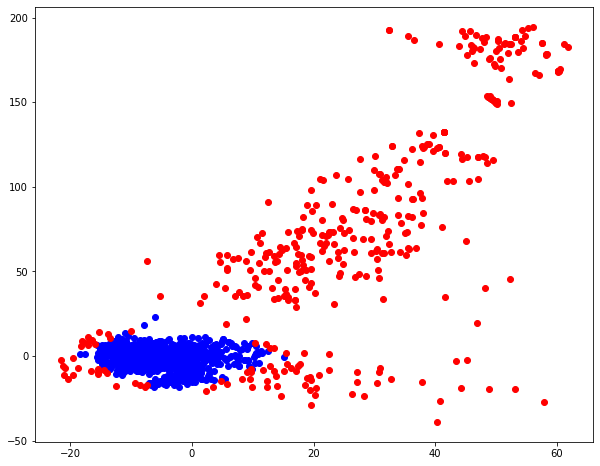

In [26]:
fig = plt.figure(figsize=(10,8))
plt.scatter(Zenc[y==0,0], Zenc[y==0,1], color="blue")
plt.scatter(Zenc[y==1,0], Zenc[y==1,1], color="red")
plt.show()

fig = plt.figure(figsize=(10,8))
plt.scatter(Zenc[y_pred==0,0], Zenc[y_pred==0,1], color="blue")
plt.scatter(Zenc[y_pred==1,0], Zenc[y_pred==1,1], color="red")
plt.show()